<a href="https://colab.research.google.com/github/CassieHuang22/CIS581-Final-Project-Masked-Facial-Recognition/blob/main/visualization_demo_masked.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualizations and Demo for Masked Faces
The following notebook creates a confusion matrix for our masked dataset and runs a demo using new photos not in the data.

In [ ]:
!pip install facenet-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 36.0 MB/s 


In [ ]:
import torchvision
import torch
from torchvision import transforms
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from facenet_pytorch import InceptionResnetV1
import numpy as np
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd "/content/drive/MyDrive/CIS5810/Final Project/Model Weights Masked"

/content/drive/MyDrive/CIS5810/Final Project/Model Weights Masked


## Dataset and Model

In [ ]:
class face_rec(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.inception_resnet = InceptionResnetV1(pretrained='vggface2').eval()
    self.fc_layers = torch.nn.Sequential(torch.nn.Linear(512, 1), torch.nn.Sigmoid())

  def forward(self, img1, img2):
    encoding_1 = self.inception_resnet(img1)
    encoding_2 = self.inception_resnet(img2)
    input_fc = torch.abs(encoding_1 - encoding_2)
    out = self.fc_layers(input_fc)
    return out

In [ ]:
from torch.utils.data import Dataset

In [ ]:
import os
from typing import Any, Callable, Dict, List, Optional, Tuple, Union

from PIL import Image

from torchvision.datasets.utils import check_integrity, download_and_extract_archive, download_url, verify_str_arg
from torchvision.datasets import VisionDataset
from torchvision import transforms

In [ ]:
class _LFW(VisionDataset):

    base_folder = "lfw-py"
    download_url_prefix = "http://vis-www.cs.umass.edu/lfw/"

    file_dict = {
        "original": ("lfw", "lfw.tgz", "a17d05bd522c52d84eca14327a23d494"),
        "funneled": ("lfw_funneled", "lfw-funneled.tgz", "1b42dfed7d15c9b2dd63d5e5840c86ad"),
        "deepfunneled": ("lfw-deepfunneled", "lfw-deepfunneled.tgz", "68331da3eb755a505a502b5aacb3c201"),
    }
    checksums = {
        "pairs.txt": "9f1ba174e4e1c508ff7cdf10ac338a7d",
        "pairsDevTest.txt": "5132f7440eb68cf58910c8a45a2ac10b",
        "pairsDevTrain.txt": "4f27cbf15b2da4a85c1907eb4181ad21",
        "people.txt": "450f0863dd89e85e73936a6d71a3474b",
        "peopleDevTest.txt": "e4bf5be0a43b5dcd9dc5ccfcb8fb19c5",
        "peopleDevTrain.txt": "54eaac34beb6d042ed3a7d883e247a21",
        "lfw-names.txt": "a6d0a479bd074669f656265a6e693f6d",
    }
    annot_file = {"10fold": "", "train": "DevTrain", "test": "DevTest"}
    names = "lfw-names.txt"

    def __init__(
        self,
        root: str,
        split: str,
        image_set: str,
        view: str,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        download: bool = False,
    ) -> None:
        super().__init__(os.path.join(root, self.base_folder), transform=transform, target_transform=target_transform)

        self.image_set = verify_str_arg(image_set.lower(), "image_set", self.file_dict.keys())
        images_dir, self.filename, self.md5 = self.file_dict[self.image_set]

        self.view = verify_str_arg(view.lower(), "view", ["people", "pairs"])
        self.split = verify_str_arg(split.lower(), "split", ["10fold", "train", "test"])
        self.labels_file = f"{self.view}{self.annot_file[self.split]}.txt"
        self.data: List[Any] = []

        if download:
            self.download()

        #if not self._check_integrity():
        #    raise RuntimeError("Dataset not found or corrupted. You can use download=True to download it")

        self.images_dir = os.path.join(self.root, images_dir)

    def _loader(self, path: str) -> Image.Image:
        with open(path, "rb") as f:
            img = Image.open(f)
            return img.convert("RGB")

    def _check_integrity(self) -> bool:
        st1 = check_integrity(os.path.join(self.root, self.filename), self.md5)
        st2 = check_integrity(os.path.join(self.root, self.labels_file), self.checksums[self.labels_file])
        if not st1 or not st2:
            return False
        if self.view == "people":
            return check_integrity(os.path.join(self.root, self.names), self.checksums[self.names])
        return True

    def download(self) -> None:
        if self._check_integrity():
            print("Files already downloaded and verified")
            return
        url = f"{self.download_url_prefix}{self.filename}"
        download_and_extract_archive(url, self.root, filename=self.filename, md5=self.md5)
        download_url(f"{self.download_url_prefix}{self.labels_file}", self.root)
        if self.view == "people":
            download_url(f"{self.download_url_prefix}{self.names}", self.root)

    def _get_path(self, identity: str, no: Union[int, str]) -> str:
        return os.path.join(self.images_dir, identity, f"{identity}_{int(no):04d}.jpg")

    def extra_repr(self) -> str:
        return f"Alignment: {self.image_set}\nSplit: {self.split}"

    def __len__(self) -> int:
        return len(self.data)


In [ ]:
import numpy as np
cache_present = list(np.load('./cache_present.npy'))
cache_absent = list(np.load('./cache_absent.npy'))

In [ ]:
def file_exists(path):
  if path in cache_present:
    return True
  elif path in cache_absent:
    return False
  else:
    if os.path.isfile(path):
      cache_present.append(path)
      return True
    else:
      cache_absent.append(path)
      return False

In [ ]:
class LFWPairs(_LFW):
    """`LFW <http://vis-www.cs.umass.edu/lfw/>`_ Dataset.

    Args:
        root (string): Root directory of dataset where directory
            ``lfw-py`` exists or will be saved to if download is set to True.
        split (string, optional): The image split to use. Can be one of ``train``, ``test``,
            ``10fold``. Defaults to ``10fold``.
        image_set (str, optional): Type of image funneling to use, ``original``, ``funneled`` or
            ``deepfunneled``. Defaults to ``funneled``.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomRotation``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.

    """

    def __init__(
        self,
        root: str,
        split: str = "10fold",
        image_set: str = "funneled",
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        download: bool = False,
    ) -> None:
        super().__init__(root, split, image_set, "pairs", transform, target_transform, download)

        self.pair_names, self.data, self.targets = self._get_pairs(self.images_dir)

    def _get_pairs(self, images_dir: str) -> Tuple[List[Tuple[str, str]], List[Tuple[str, str]], List[int]]:
        pair_names, data, targets = [], [], []
        with open(os.path.join(self.root, self.labels_file)) as f:
            lines = f.readlines()
            if self.split == "10fold":
                n_folds, n_pairs = lines[0].split("\t")
                n_folds, n_pairs = int(n_folds), int(n_pairs)
            else:
                n_folds, n_pairs = 1, int(lines[0])
            s = 1

            for fold in range(n_folds):
                matched_pairs = [line.strip().split("\t") for line in lines[s : s + n_pairs]]
                unmatched_pairs = [line.strip().split("\t") for line in lines[s + n_pairs : s + (2 * n_pairs)]]
                s += 2 * n_pairs
                for pair in matched_pairs:
                    img1, img2, same = self._get_path(pair[0], pair[1]), self._get_path(pair[0], pair[2]), 1
                    pair_names.append((pair[0], pair[0]))
                    if file_exists(img1) and file_exists(img2):
                      data.append((img1, img2))
                      targets.append(same)
                for pair in unmatched_pairs:
                    img1, img2, same = self._get_path(pair[0], pair[1]), self._get_path(pair[2], pair[3]), 0
                    pair_names.append((pair[0], pair[2]))
                    if file_exists(img1) and file_exists(img2):
                      data.append((img1, img2))
                      targets.append(same)
                    

        return pair_names, data, targets

    def __getitem__(self, index: int) -> Tuple[Any, Any, int]:
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image1, image2, target) where target is `0` for different indentities and `1` for same identities.
        """
        img1, img2 = self.data[index]
        img1, img2 = self._loader(img1), self._loader(img2)
        target = self.targets[index]

        if self.transform is not None:
            img1, img2 = self.transform(img1), self.transform(img2)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img1, img2, target


## Evaluation

In [ ]:
test_transforms = transforms.Compose([transforms.Resize((160, 160)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 

In [ ]:
lfw_test = LFWPairs(".", split='test', transform=test_transforms)

In [ ]:
testloader = torch.utils.data.DataLoader(lfw_test, batch_size=16)
testloader_random = torch.utils.data.DataLoader(lfw_test, batch_size=16, shuffle=True)

In [ ]:
model = face_rec().to(device)

  0%|          | 0.00/107M [00:00<?, ?B/s]

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/CIS5810/Final Project/Model Weights Masked/MASKED_weights_lr0.001_wd0.01_epoch20'))

<All keys matched successfully>

In [ ]:
model.eval()

face_rec(
  (inception_resnet): InceptionResnetV1(
    (conv2d_1a): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (conv2d_2a): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (conv2d_2b): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2d_3b): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=

In [ ]:
def evaluate_model(net):
  criterion = torch.nn.BCELoss()
  with torch.no_grad():
      correct = 0
      total = 0
      val_loss = 0
      count = 0 
      for test_img1, test_img2, labels in testloader:
        test_images1 = test_img1.to(device)
        test_images2 = test_img2.to(device)
        labels = labels.to(device)
        outputs = net(test_images1, test_images2)
        val_loss += criterion(torch.flatten(outputs), labels.float()).item() * test_images1.shape[0]
        predictions = torch.flatten(torch.tensor(outputs.clone().detach() > 0.5, dtype=int))
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
  return correct / total

In [ ]:
evaluate_model(model)

<ipython-input-18-889241cda64a>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.flatten(torch.tensor(outputs.clone().detach() > 0.5, dtype=int))


0.8199195171026157

## Creating Confusion Matrix

In [ ]:
to_pil = transforms.ToPILImage()

In [ ]:
predictions_all = np.array([])
labels_all = np.array([])

In [ ]:
# To generate confusion matrix
for test_img1, test_img2, labels in testloader_random:
      test_images1 = test_img1.to(device)
      test_images2 = test_img2.to(device)
      labels = labels.to(device)
      outputs = model(test_images1, test_images2)
      predictions = torch.flatten(torch.tensor(outputs.clone().detach() > 0.5, dtype=int))
      predictions_all = np.hstack([predictions_all, predictions.cpu().detach().numpy()])
      labels_all = np.hstack([labels_all, labels.cpu().detach().numpy()])

<ipython-input-22-4ef5e915bd80>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.flatten(torch.tensor(outputs.clone().detach() > 0.5, dtype=int))


In [ ]:
from sklearn.metrics import confusion_matrix
cm_matrix = confusion_matrix(labels_all, predictions_all)

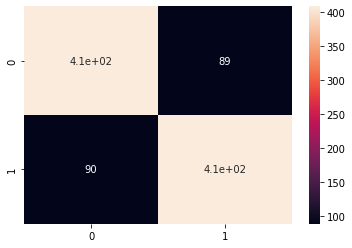

In [ ]:
import pandas as pd
import seaborn as sns
cm_df = pd.DataFrame(cm_matrix)
sns.heatmap(cm_df, annot=True)

## Demo

In [ ]:
# A function to verify if two faces are of the same person
def verify(img1_path, img2_path):
  img1 = Image.open(img1_path)
  img1_t = test_transforms(img1).reshape(-1, 3, 160, 160).to(device)
  img2 = Image.open(img2_path)
  img2_t = test_transforms(img2).reshape(-1, 3, 160, 160).to(device)
  output = model(img1_t, img2_t)
  if output.item() > 0.5:
    return 1
  else:
    return 0


In [ ]:
resize = transforms.Resize((160, 160))

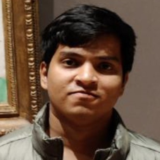

In [ ]:
resize(Image.open('Vaibhav/Vaibhav_0001.jpeg'))

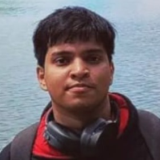

In [ ]:
resize(Image.open('Vaibhav/Vaibhav_0002.jpeg'))

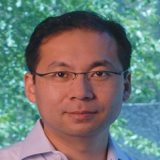

In [ ]:
resize(Image.open('Jianbo/Jianbo_0001.jpeg'))

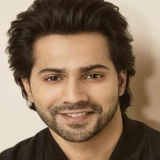

In [ ]:
resize(Image.open('Varun/Varun_0001.jpeg'))

In [ ]:
verify('Vaibhav/Vaibhav_0001.jpeg', 'Vaibhav/Vaibhav_0002.jpeg')

1

In [ ]:
verify('Vaibhav/Vaibhav_0001.jpeg', 'Jianbo/Jianbo_0001.jpeg')

0

In [ ]:
verify('Vaibhav/Vaibhav_0001.jpeg', 'Varun/Varun_0001.jpeg')

0

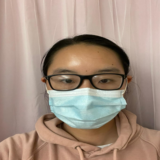

In [ ]:
resize(Image.open('./Cassie/Cassie_0001.JPG'))

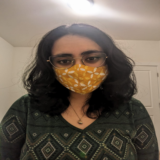

In [ ]:
resize(Image.open('./Rasya/Rasya_0001.JPG'))

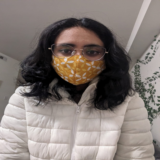

In [ ]:
resize(Image.open('./Rasya/Rasya_0002.JPG'))

In [ ]:
verify('Rasya/Rasya_0001.JPG', 'Rasya/Rasya_0002.JPG')

1

In [ ]:
verify('Rasya/Rasya_0001.JPG', 'Cassie/Cassie_0001.JPG')

0